## Import libraries

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary
from model import ConvNet
from utils import CustomDataset
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torch.ao.quantization import quantize_dynamic
from onnxruntime.quantization import quantize_static, CalibrationDataReader, QuantType, QuantFormat, CalibrationMethod
import onnxruntime as ort
from sklearn.metrics import classification_report
from transfer_learning import pca_draw, draw_gradCAM, train, test, MyCalibrationDataReader, onnx_test

## Set parameter

In [2]:
IMAGE_SIZE = 64
BATCH_SIZE = 16
NUM_WORKERS = 4 
EPOCH = 2
LEARING_RATE = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

---

## Set dataloaders
- Intensity 분초는 'model.py'에 있는 것을 사용햇습니다.
- training과 validation data set은 8:2로 나누었습니다.
- 일반적으로, min-max나 standard 스케일링을 천처리에 사용합니다. 이 경우는 TorchVision의 transforms를 이용한 standard 스케일링을 사용했습니다.

---

In [3]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225], inplace=False),
])

train_data = CustomDataset(True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,
                                      num_workers=NUM_WORKERS, pin_memory=True)

val_data = CustomDataset(False, transform=transform)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False,
                                      num_workers=NUM_WORKERS, pin_memory=True)

---

## Load the current model
1. 대상 모델을 읽어옵니다.
2. 모델의 parameters를 파일로 부터 읽어옵니다.
3. 해당 모델의 weight를 고정합니다.

---

In [4]:
model = ConvNet()
model.load_state_dict(torch.load("conv_net.pth", map_location=device, weights_only=True))
# Freez weights
for param in model.parameters():
    param.requires_grad = False

/home/mj/anaconda3/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


---

## The distribution of the current feature
각 class는 이미 거의 분류되어있는 상태이므로, 몇번의 학습만 필요할 것으로 보입니다.

---

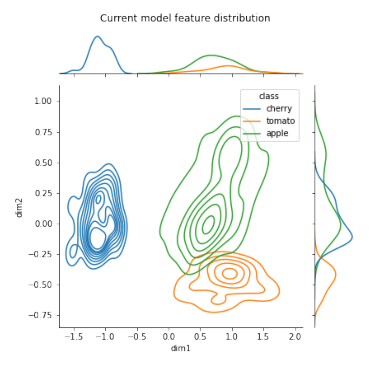

In [5]:
pca_draw(model.to(device), train_loader, 'Current model feature distribution', 'current_feature_scatter.png')
scatter_plot = Image.open('current_feature_scatter.png')
plt.imshow(scatter_plot)
plt.axis('off')
plt.show()

---

## Check the current GradCAM.
현재 모델의 GradCAM을 확인합니다.
- GradCAM이 잘 활성화 되지 않는 것으로 보아, standard 스캐일링의 평균과 표준편차가 잘 맞지는 않는 것으로 보입니다.
- 하지만, 특징 벡터가 분리되어 있으므로 크게 중요하지 않습니다.

---

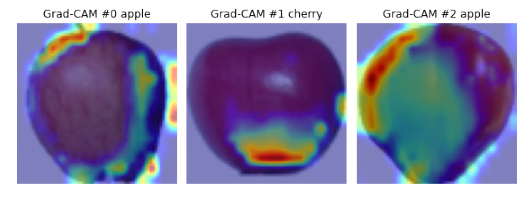

In [6]:
draw_gradCAM(model, transform, 'before_train.png', ['apple', 'lychee', 'cherry', 'banana', 'orange'])
current_grad_cam = Image.open('before_train.png')
plt.imshow(current_grad_cam)
plt.axis('off')
plt.show()

---

## Replace the head layer for transfer learning 

3개의 class를 학습하기 위해 head layer를 교체합니다.

---

In [7]:
# New head for 3 class
model.fc = nn.Linear(64 * 8 * 8, 3)

model = model.to(device)
summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
       BatchNorm2d-2           [-1, 16, 64, 64]              32
              SiLU-3           [-1, 16, 64, 64]               0
         MaxPool2d-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,640
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              SiLU-7           [-1, 32, 32, 32]               0
         MaxPool2d-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          18,496
      BatchNorm2d-10           [-1, 64, 16, 16]             128
             SiLU-11           [-1, 64, 16, 16]               0
        MaxPool2d-12             [-1, 64, 8, 8]               0
           Linear-13                    [-1, 3]          12,291
Total params: 36,099
Trainable params: 

---

## Set loss function and optimizer.
- multi-class를 학습하기 위해 cross-entroyp loss를 사용하였습니다.
- 일반적으로 Adam optimizer를 사용하기 때문에 사용하였습니다.
    - Adam optimizer는 Momentum과 RMSprop를 합친 것과 같습니다. 그러므로 두 최적화에 대한 장점을 모두 가지고 있습니다.

---

In [8]:
loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=LEARING_RATE, weight_decay=0.001)

## Training step

In [9]:
# training
for i in range(EPOCH):
    train(model, train_loader, i, loss_f, optimizer)
    test(model, val_loader)

eval acc: 0.53125
eval acc:  0.5
1 epoch loss: 0.712935, acc: 0.625 [----0/  242]
1 epoch loss: 0.052675, acc:  1.0 [---80/  242]
1 epoch loss: 0.006652, acc:  1.0 [--160/  242]
1 epoch loss: 0.001097, acc:  1.0 [---30/  242]
eval acc: 0.9375


---

## Change of GradCAM
- 이제 GradCAM이 물체에 집중합니다.
- 토마토의 경우, 물체의 외각부위에 더 집중 하는 것으로 보입니다.
- 체리의 경우 텍스쳐에 더 집중 하는 것으로 보입니다.


---

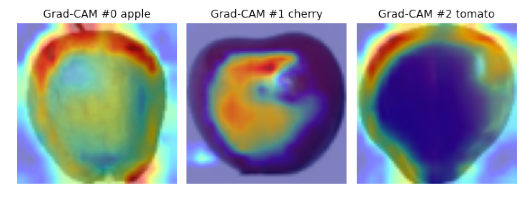

In [10]:
draw_gradCAM(model, transform, 'after_train.png', ['apple', 'cherry', 'tomato'])
current_grad_cam = Image.open('after_train.png')
plt.imshow(current_grad_cam)
plt.axis('off')
plt.show()

--- 

## Quantize the model and export it as an ONNX file
* Pytorch를 이용한 양자화를 수행하면 ONNX 라이브러리가 quantized::linear_dynamic를 exporting하지 못합니다.
* 그러므로, 저는 먼저 PyTorch를 이용하여 ONNX 모델을 추출하고, onnxruntime을 이용하여 양자화를 진행했습니다.
* 양자화 단계
    1. 32-bit floating-point ONNX 파일을 pytorch를 이용하여 만듭니다.
    2. ONNX 파일을 onnxruntime을 이용하여 양자화 합니다.(conv layer를 양자화 하려면 static quantize를 사용해야 합니다.
    3. Read the quantized ONNX model and test it
    
---

In [11]:
# quantization
device = 'cpu'
dummy_input = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE)

torch.onnx.export(
    model.to(device),           # 모델
    dummy_input,                # 입력값
    "transfer_fp32.onnx",       # 저장 파일명
    export_params=True,         # 파라미터 포함
    opset_version=13,           # ONNX opset version
    do_constant_folding=True,   # 상수 폴딩 최적화
    input_names=['input'],      # 입력 이름
    output_names=['output'],    # 출력 이름
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [12]:
#### Quantization to Int8
reader = MyCalibrationDataReader(val_loader, 'input')
quantize_static(
    model_input="transfer_fp32.onnx",
    model_output="transfer_int8.onnx",
    calibration_data_reader=reader,
    quant_format=QuantFormat.QOperator,
    activation_type=QuantType.QInt8,
    weight_type=QuantType.QInt8,
    per_channel=False,
    reduce_range=False
)

# test quantization model
print('============== quantization onnx model test ==================')
print(onnx_test('transfer_int8.onnx', val_loader))

  elem_type: 7
  shape {
  }
}
.
  elem_type: 7
  shape {
    dim {
      dim_value: 1
    }
  }
}
.


============== quantization onnx model test ==================
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        26
           2       1.00      1.00      1.00        10

    accuracy                           1.00        62
   macro avg       1.00      1.00      1.00        62
weighted avg       1.00      1.00      1.00        62

1.0
